## mapping tests 

In [2]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
import random
from snipgenie import trees, app, snp_typing
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [142]:
counties = gpd.read_file('https://github.com/dmnfarrell/snipgenie/raw/master/maps/ireland_counties.zip?raw=true')

## make fake data for map/db testing

In [272]:
meta = pd.read_csv('ireland_metadata.csv',index_col=0)
meta = meta.drop(columns=['filename','pair'])
meta = meta.rename(columns={'SB':'spoligotype'})
meta['species'] = meta.species.fillna('Cow')
meta=meta.set_index('name')

In [273]:
def make_points(x):
    """Make points"""

    if x.county == 'Wicklow':
        bounds=(-6.7,52.8,-6.1,53.2)
    elif x.county == 'Monaghan':
        bounds = (-6.0,54.0,-7.1,54.5)
    else:
        bounds = (-6.4,53.8,-6.1,54.2)
    points = []
    minx, miny, maxx, maxy = bounds   
    point = (random.uniform(minx, maxx), random.uniform(miny, maxy))
    return point

In [274]:
#make random points inside geometry

from shapely.geometry import Point
def random_point_in_shp(x):
   
    if x.county not in counties.NAME_TAG.unique():
        x.county=random.choice(['Armagh','Down'])
    shp = counties[counties.NAME_TAG==x.county].iloc[0] 
    #print (shp)
    within = False
    bounds = shp.geometry.bounds    
    while within is False:
        x = np.random.uniform(bounds[0], bounds[2])
        y = np.random.uniform(bounds[1], bounds[3])        
        within = shp.geometry.contains(Point(x, y))
        #print (within)
    return x,y

#meta.apply(random_point_in_shp,1)

In [275]:
meta['coord'] = meta.apply(random_point_in_shp,1)
meta[['LONG','LAT']] = pd.DataFrame(meta.coord.tolist(), index=meta.index)

In [276]:
sdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
#print (sdist)

def find_neighbours(x, n=4):
    """find neighbours from snp distance matrix"""
  
    vals = list(x.sort_values()[1:n].index)
    return ';'.join(vals)

nearest = sdist.apply(find_neighbours,1)
#nearest
meta['nearest'] = nearest

In [277]:
#encode snp data into field
snpm = pd.read_csv('/storage/btbgenie/all_ireland_results/core.txt',sep=' ').set_index('pos').T
snpm = snpm.fillna('N')
meta['snps'] = snpm.apply(snp_typing.encode_snps,1)

In [278]:
print (meta[:4])
meta.to_csv('ireland_test_data.csv')

              sample county species spoligotype SequenceName  ClusterNumber clade                                    coord      LONG        LAT                        nearest  \
name                                                                                                                                                                             
ERR125617  ERR125617     NI     Cow      SB0140    ERR125617              7  NI-1   (-6.13175852638607, 54.14069632027449) -6.131759  54.140696  ERR125614;ERR125619;ERR125609   
ERR125622  ERR125622     NI     Cow      SB0140    ERR125622              7  NI-1   (-6.37004165927813, 54.21544270699138) -6.370042  54.215443  ERR125614;ERR125619;ERR125609   
ERR125598  ERR125598     NI     Cow      SB0140    ERR125598              7  NI-1  (-5.966406546879984, 54.13183582175392) -5.966407  54.131836  ERR125625;ERR125601;ERR125605   
ERR125612  ERR125612     NI     Cow      SB0140    ERR125612              7  NI-1   (-6.649228264846865, 54.20

<AxesSubplot:>

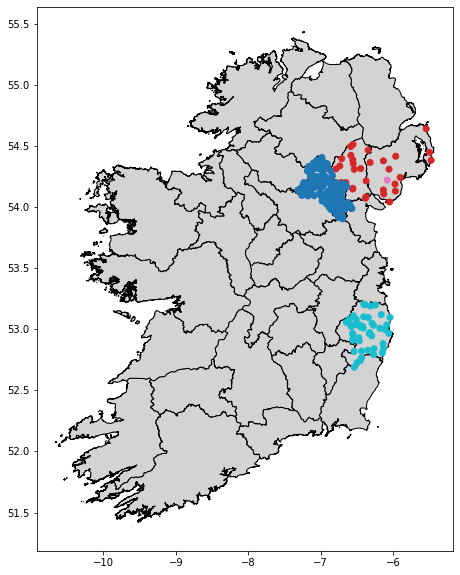

In [279]:
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.LONG, meta.LAT),crs='EPSG:4326')
fig,ax=plt.subplots(1,1,figsize=(10,10))
counties.plot(ax=ax,color='lightgray',ec='black')
gdf.plot(ax=ax,column='county')